## In Deep Learning
- Many layers: compositionality
- Convolutions: locality + stationarity of images
- Pooling: Invariance of object class to translations

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# to count the number of parameters
def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Loading the MNIST Dataset

We will use torch functionalities to download the data easily along with some minor pre-processing functions.

In [5]:
input_size = 28 * 28
output_size = 10

train_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train = True, download = True, 
                                                            transform = transforms.Compose([
                                                                transforms.ToTensor(),
                                                                transforms.Normalize((0.1307,), (0.3081,))
                                                            ])),
                                            batch_size = 64, shuffle = True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST('../data', train = False, 
                                                            transform = transforms.Compose([
                                                                transforms.ToTensor(),
                                                                transforms.Normalize((0.1307,), (0.3081,))
                                                            ])),
                                            batch_size = 1000, shuffle = True)

100.1%

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


113.5%

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


100.4%

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


180.4%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/media/prashant/HDD/Workspace/GitHub_Repositories/PyTorch_for_Deep_Learning/venv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


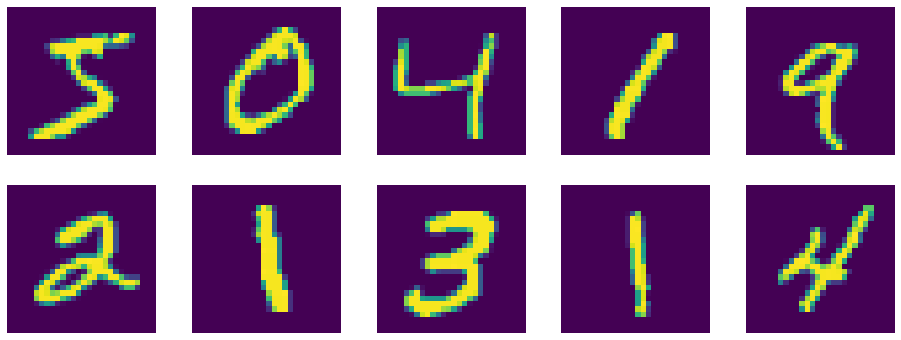

In [6]:
# plotting some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')

## Creating the Model Classes

In [7]:
# Creating a Fully Connected Network
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size) # Flattening the features to feed to the full connected layers
        return self.network(x)

In [8]:
# Creating Convolutinal Network
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_features
        self.conv1 = nn.Conv2d(in_channels= 1 , out_channels= n_feature, kernel_size = 5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size= 5)
        self.fc1 = nn.Linear(n_feature * 4 * 4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, verbose = False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size = 2)
        x = x.view(-1, self.n_feature * 4 * 4) # Flattening the features to feed to the full connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [44]:
accuracy_list = []
def train(epoch, model, perm = torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # sending to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28 * 28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm = torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # sending to device
        data, target = data.to(device), target.to(device)
        
        # permuting the pixels 
        data = data.view(-1, 28 * 28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction = 'sum').item() # sum to get the batch loss
        pred = output.data.max(1, keepdim = True)[1] # getting the index of the max log probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest Set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            accuracy))

## Training a Small Fully Connected Network

In [46]:
n_hidden = 8 

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr = 0.01, momentum = 0.5)
print('Number of Parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 2):
    train(epoch, model_fnn)
    test(model_fnn)

Number of Parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.324030
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.783732
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.414057
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.958160
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.138294
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.501868
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.895273
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.822449
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.589684
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.541056

Test Set: Average loss: 0.5739, Accuracy: 8323/10000 (83%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.662531
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.532736
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.521319
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.482993
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.506506
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.298154
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.496604
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.784099
Train Epoch: 1 [51200/60

## Training a Convolutional Network with same number of parameters

In [47]:
# Training settings
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr = 0.01, momentum = 0.5)
print('Number of Parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 2):
    train(epoch, model_cnn)
    test(model_cnn)

Number of Parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.310686
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.426329
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.366174
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.290830
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.310044
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.193027
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.206488
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.180909
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.123226
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.136701

Test Set: Average loss: 0.1595, Accuracy: 9496/10000 (95%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.242380
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.157866
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.312855
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.146860
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.198459
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.169926
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.160579
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.054300
Train Epoch: 1 [51200/60

Having same number of parameters, the convolutional neural network performs better because of its prior knowledge about the images

- Use of convolution: Locality and stationarity in images
- Pooling: builds some translation invariance

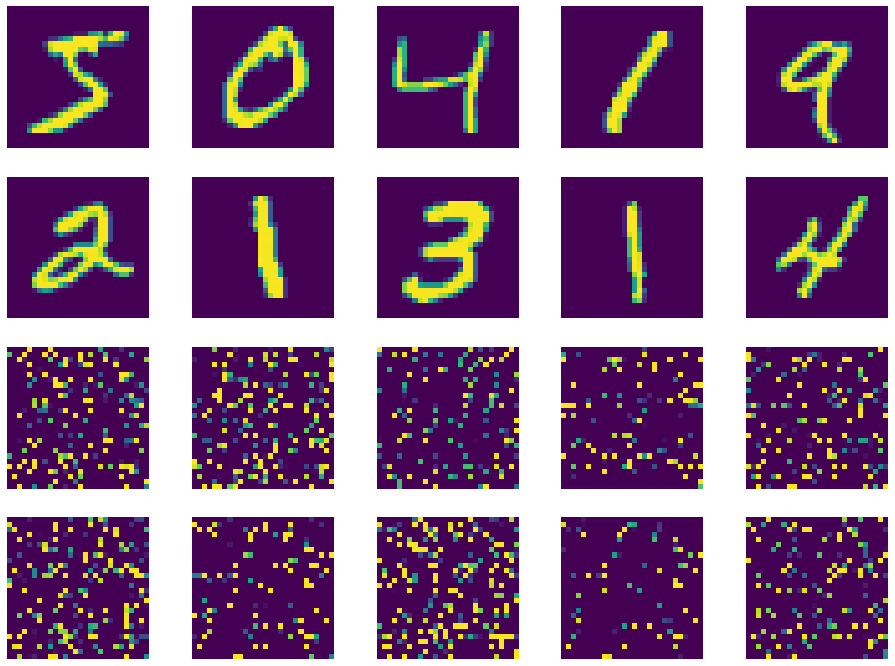

In [58]:
perm = torch.randperm(784)
plt.figure(figsize = (16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permuting pixels
    image_perm = image.view(-1, 28 * 28).clone() # flattening the pixels
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i+1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i+11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

## Convolutional Network with Permuted Pixels

In [59]:
# training settings 
n_features = 6 # number of filters

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr = 0.01, momentum = 0.5)
print('Number of Parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 2):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of Parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.304966
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.255561
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.216744
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.903062
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.338905
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.044364
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.943533
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.923887
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.566529
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.449547

Test Set: Average loss: 0.5699, Accuracy: 8171/10000 (82%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.789950
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.347302
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.467647
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.367004
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.624115
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.539626
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.456455
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.250540
Train Epoch: 1 [51200/60

## Fully Connected with Permuted Pixels

In [60]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 2):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.361111
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.867089
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.114808
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.758454
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.754103
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.456775
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.433415
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.497927
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.425891
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.504271

Test Set: Average loss: 0.3979, Accuracy: 8869/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.427143
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.327016
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.181908
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.882301
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.269251
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.412732
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.386342
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.260092
Train Epoch: 1 [51200/60

When the pixels are randomly scrambled the performance of the convolutional neural networks decrease but FNN performance is still similar as it was previously.m
- ConvNet makes the assumption that pixels lie on a grid and are stationary/ local.
- It loses performance when this assumption is wrong.
- The fully-connected network does not make this assumption
- It does less well when it is true, since it doesn't take advantage of this prior knowledge
- But it doesn't suffer when assumption is wrong

In [61]:
print(dir(model_cnn))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', 'children', 'conv1', 'conv2', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'fc1', 'fc2', 'float', 'fo

In [62]:
print(dir(model_fnn))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_name', '_load_from_state_dict', '_load_state_dict_pre_hooks', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16', 'buffers', 'children', 'cpu', 'cuda', 'double', 'dump_patches', 'eval', 'extra_repr', 'float', 'forward', 'half', 'input_size', 'l